> __Example 4.2: Jack's Car Rental__ Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is $n$ is $\frac{\lambda^n}{n!}e^{-\lambda}$, where $\lambda$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

From _Reinforcement Learning: An Introduction_ by Richard S. Sutton and Andrew G. Barto

(https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node43.html)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
from math import exp, factorial

In [2]:
MAX_CARS = 20 # maximum #cars in a location
MOVE_COST = 2 # cost for moving a car
RENTAL_REWARD = 10 # reward from one rented car
AVG_RENTAL_1 = 3 # average #rentals at location 1
AVG_RENTAL_2 = 4 # average #rentals at location 2
AVG_RETURN_1 = 3 # average #returns at location 1
AVG_RETURN_2 = 2 # average #returns at location 2
DISCOUNT = 0.9

In [3]:
'''
Poisson distribution for X<k
(Poisson(X>=k) is small enough to be ignored)
-- poisson = dict: lambda_value -> list of (x, probabilities
'''
poisson = {}
k = 30

def poisson_prob(lmbda, x):
    return exp(-lmbda)*pow(lmbda,x)/factorial(x)

# populate poisson
for lmbda in [AVG_RENTAL_1, AVG_RENTAL_2, AVG_RETURN_1, AVG_RETURN_2]:
    poisson[lmbda] = [poisson_prob(lmbda, x) for x in range(k)]

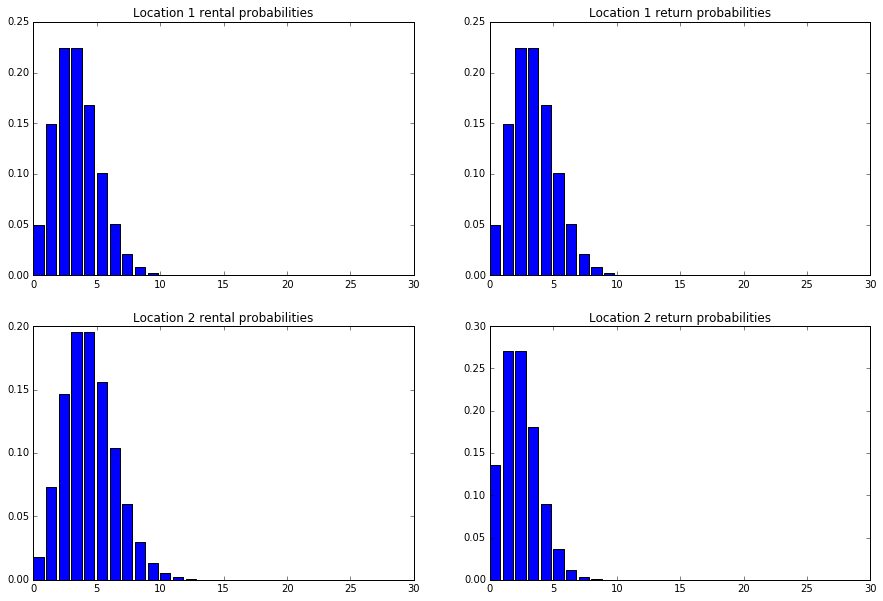

In [4]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221)
ax.bar(range(k), poisson[AVG_RENTAL_1])
ax.set_title('Location 1 rental probabilities')
ax = fig.add_subplot(222)
ax.bar(range(k), poisson[AVG_RETURN_1])
ax.set_title('Location 1 return probabilities')
ax = fig.add_subplot(223)
ax.bar(range(k), poisson[AVG_RENTAL_2])
ax.set_title('Location 2 rental probabilities')
ax = fig.add_subplot(224)
ax.bar(range(k), poisson[AVG_RETURN_2])
ax.set_title('Location 2 return probabilities')
plt.show()

In [5]:
'''
A state is a tuple (#cars in location 1)x(#cars in location 2)
-- states = list of states
'''
states = list(product(range(MAX_CARS+1), repeat=2))

'''
An action, n, is the number of cars moved from location 1 to location 2
(negative means to move cars from location 2 to location 1)
The possible set of actions for a state
is the intersection of [-n2..n1] and [-5..5],
where n1, n2 are the #cars in location 1 and location 2, respectively
-- actions = dict: state -> list of actions
'''
actions = dict(((n1, n2), list(range(max(-5,-n2), min(n1,5)+1))) for n1, n2 in states)

'''
Probabilities of getting into a new state
after an action from some state
-- transitions = dict: state -> action -> state -> probability 
'''
transitions = {}

'''
Expected rewards after taking an action from some state
-- rewards = dict: state -> action -> reward
'''
rewards = {}

'''
Calculate
 - expected rewards from rental, and
 - probability distribution of cars left
after a day of business starting with num_cars cars
'''
def expected_day(num_cars, avg_rental, avg_return):
    pd = poisson[avg_rental]
    rewards = 0
    cars_left_probs = [0]*(MAX_CARS+1)
    for x, xprob in enumerate(poisson[avg_rental]):
        rental = min(x, num_cars)
        rewards += RENTAL_REWARD*rental*xprob
        for y, yprob in enumerate(poisson[avg_return]):
            cars_left = min(num_cars-rental+y, MAX_CARS)
            cars_left_probs[cars_left] += xprob*yprob
    return (rewards, cars_left_probs)

# populate transitions, and rewards
for s in states:
    n1, n2 = s
    rewards[s] = {}
    transitions[s] = {}
    for a in actions[s]: # for each possible action at state
        c1, c2 = n1-a, n2+a # number of cars after moving cars

        exp_rwd1, car_probs1 = expected_day(c1, AVG_RENTAL_1, AVG_RETURN_1)
        exp_rwd2, car_probs2 = expected_day(c2, AVG_RENTAL_2, AVG_RETURN_2)
        
        rewards[s][a] = exp_rwd1 + exp_rwd2 - MOVE_COST*abs(a)
        transitions[s][a] = {}
        for cars1, prob1 in enumerate(car_probs1):
            for cars2, prob2 in enumerate(car_probs2):
                transitions[s][a][cars1, cars2] = prob1*prob2

In [6]:
'''
Since all states have action 0 (move no car),
we can start off with this do-nothing policy
-- policy = dict: state -> action
'''
init_policy = dict(zip(states, [0]*len(states)))

'''
State values
Start with all-zero
-- values = dict: state -> value
'''
init_values = dict(zip(states, [0]*len(states)))

In [7]:
'''
Compue state values given a policy
through iterative policy evaluation
'''
def eval_policy(values, policy):
    converged = False
    while not converged:
        
        # synchronous backup
        new_values = {}
        for s in states:
            action = policy[s]
            new_values[s] = rewards[s][action]
            for ns in states:
                new_values[s] += DISCOUNT*transitions[s][action][ns]*values[ns]

        max_diff = max(abs(values[s]-new_values[s]) for s in states)
        values = new_values
        converged = max_diff < 0.001
    return new_values

'''
Compute policy with respect to state values
'''
def greedy(values):
    policy = {}
    for s in states:
        max_q = -10000
        for a in actions[s]:
            q = rewards[s][a]
            q += sum(DISCOUNT*transitions[s][a][ns]*values[ns] for ns in states)
            if q > max_q:
                best_action = a
                max_q = q
        policy[s] = best_action
    return policy

In [8]:
# policy iteration
values, policies = [init_values], [init_policy]
converged = False
iter_count = 0
while not converged:
    values.append(eval_policy(values[-1], policies[-1]))
    policies.append(greedy(values[-1]))
    converged = all(policies[-1] == policies[-2] for s in states)
    iter_count += 1
    
print('Number of iterations: %d' % iter_count)

Number of iterations: 5


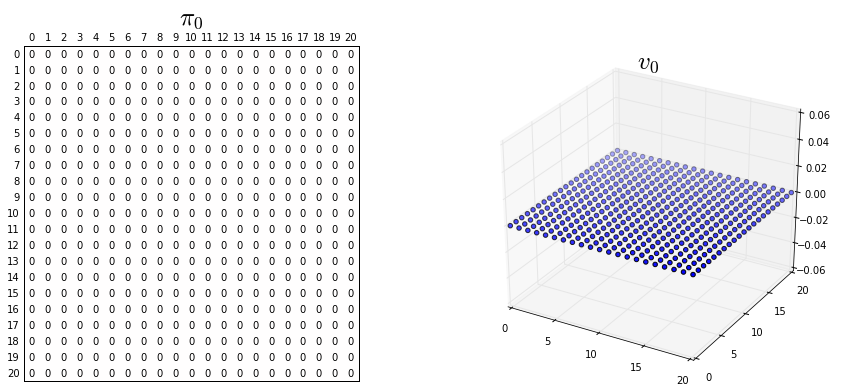

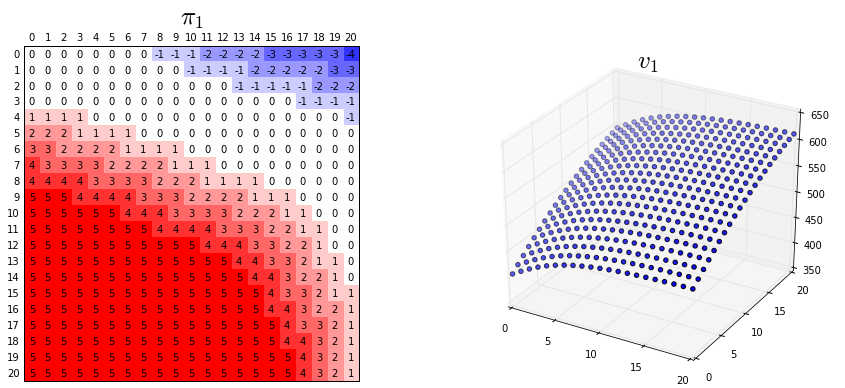

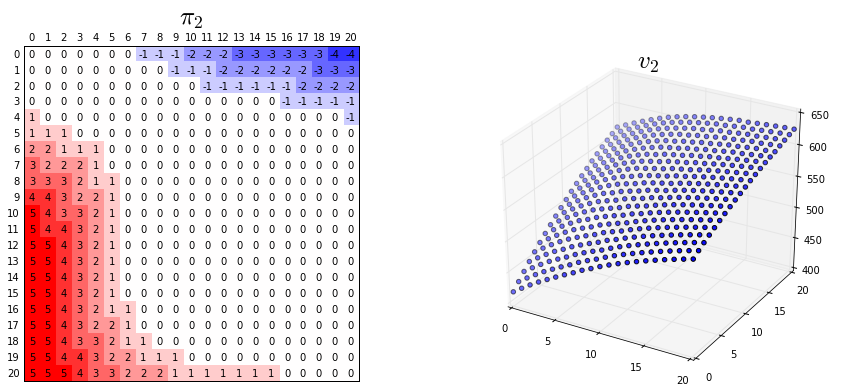

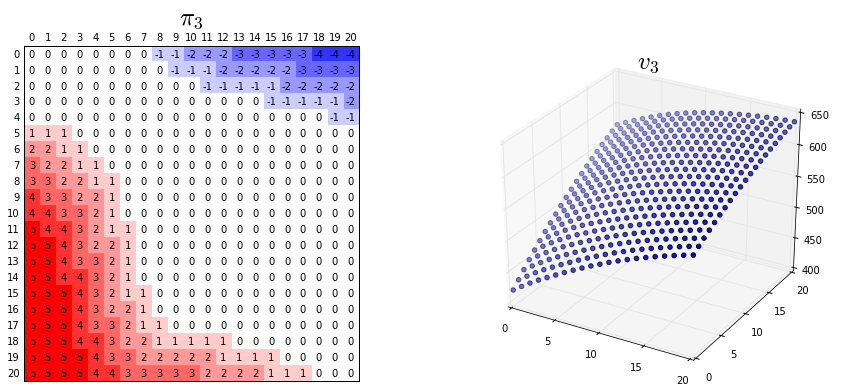

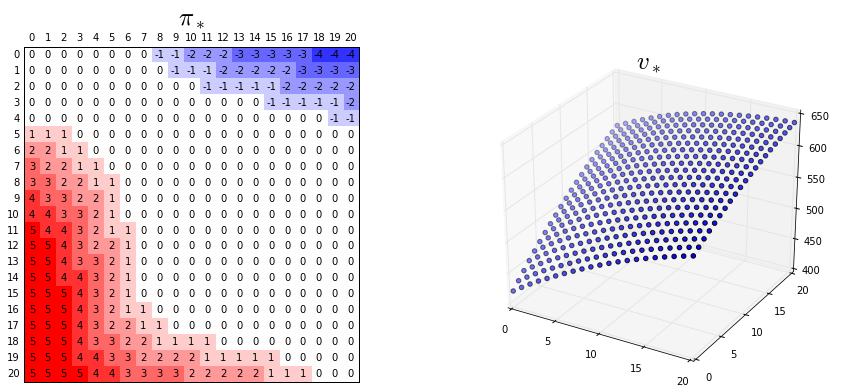

In [9]:
for step in range(iter_count):
    # policy
    dim = MAX_CARS+1
    data = [[0]*dim for x in range(dim)]
    for x, y in states:
        data[x][y] = policies[step][x, y]

    # values
    X, Y = zip(*states)
    Z = [values[step][x, y] for x, y in zip(X, Y)]


    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    ax.matshow(data, cmap=plt.cm.bwr, vmin=-5, vmax=5)
    ax.set_xticks(range(dim))
    ax.set_yticks(range(dim))
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticks([x-0.5 for x in range(1,dim)], minor=True)
    ax.set_yticks([y-0.5 for y in range(1,dim)], minor=True)
    ax.set_title('$\pi_%s$' % (step if step < iter_count-1 else '*'), fontsize=25)
    for x, y in states:
        ax.text(y, x, data[x][y], va='center', ha='center')

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter3D(X, Y, Z)
    ax.set_xlim3d(0, MAX_CARS)
    ax.set_ylim3d(0, MAX_CARS)
    ax.set_title('$v_%s$' % (step if step < iter_count-1 else '*'), fontsize=25)
    plt.show()